# Implementation of RNN based on GRU for hyperspectral image segmentation (Huston dataset)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [24]:
import torch
import torch.utils.data as dataf
import torch.nn as nn
from scipy import io
from skimage import io as skimage_io
import numpy as np
import os
import sys
import pickle
import time
import random
import matplotlib.pyplot as plt
from matplotlib import colors as c
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

## Global variables initialization

In [25]:
# define global variables
LR = 0.001
GRULayers = 2
HiddenSize = 128
Dropout = 0
Epoch = 200

batchsize = 182
batchsize_val = 14

## Function declarations

### readData

In [26]:
# this function reads data and reshapes it 
# so that the first two dimensions are special,
# the third is spectral
def readData(data_dir = "/content/drive/MyDrive/landcover/data/"):
  # read data from data_dir
  Data = skimage_io.imread(data_dir + 'CASI_SC_tif.tif')
  TrLabel = skimage_io.imread(data_dir + 'Train_samples.tif')
  TsLabel = skimage_io.imread(data_dir + 'Test_sample.tif')

  print('Data shape: {}'.format(Data.shape))
  print('Train Data shape: {}'.format(TrLabel.shape))
  print('Test Data shape: {}'.format(TsLabel.shape))

  Data = torch.from_numpy(Data.astype(np.float32))
  [L, M, N] = Data.shape
  DataTemp = torch.empty([M, N, L])

  for l in range(L):
    DataTemp[:, :, l] = Data[l, :, :]

  Data = DataTemp
  del DataTemp

  TrLabel = torch.from_numpy(TrLabel)
  TsLabel = torch.from_numpy(TsLabel)


  print('Data shape after reshape: {}'.format(list(Data.shape)))
  return Data, TrLabel, TsLabel

### printImage

In [27]:
# this function prints and saves an image
def printImage(colors, data_to_visualize, path_to_save):
  cmap = c.ListedColormap(colors)
  
  cax = plt.imshow(data_to_visualize,cmap=cmap)
  cbar = plt.colorbar(cax, ticks=np.arange(1, 16, 1), orientation='horizontal')
  cbar.ax.set_xticklabels(['grass healthy', 'grass stressed', 'grass synthetic',
                           'tree', 'soil', 'water', 'residential', 'commercial', 
                           'road', 'highway', 'railway', 'parking lot 1', 
                           'parking lot 2', 'tennis court', 'running track'], rotation=90)

  plt.axis('off')
  # save the image
  plt.savefig(path_to_save, transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)

### normalizeData

In [28]:
# this function normalizes given Data by mapping it to zero mean and one std
def normalizeData(data):
  [m, n, l] = data.shape
  for i in range(l):
      mean = torch.mean(data[:, :, i])
      std = torch.std(data[:, :, i])
      Data[:, :, i] = (data[:, :, i] - mean)/std

  print("Mean of the dataset is {}, standard deviation is {}".format(mean, std))
  return data

### constructDataForNetwork

In [29]:
# this function constructs data for network
def constructDataForNetwork(data, trLabel, tsLabel):
  # m, n are special dimensions, l is the spectral dimension
  
  [m, n, l] = data.shape 
  TotalData = torch.reshape(data, [m*n, l])

  TrainDataLabel = torch.reshape(trLabel, [m*n, 1])
  Tr_index, _ = torch.where(TrainDataLabel != 0)
  TrainData = TotalData[Tr_index, :]
  TrainDataLabel = TrainDataLabel[Tr_index, 0]

  TestDataLabel = torch.reshape(tsLabel, [m*n, 1])
  Ts_index, _ = torch.where(TestDataLabel != 0)
  TestData = TotalData[Ts_index, :]
  TestDataLabel = TestDataLabel[Ts_index, 0]
  
  TrainDataLabel = TrainDataLabel - 1
  TestDataLabel = TestDataLabel - 1
  TrainDataLabel = TrainDataLabel.long()
  TestDataLabel = TestDataLabel.long()

  TrainData = (TrainData.unsqueeze(2)).type('torch.FloatTensor') 
  TestData = (TestData.unsqueeze(2)).type('torch.FloatTensor') 
  TotalData = TotalData.unsqueeze(2).type('torch.FloatTensor') 

  print('Training size is {}, testing size is: {}'.format(list(TrainData.shape), list(TestData.shape))) 
  return TrainData, TrainDataLabel, TestData, TestDataLabel, TotalData, m, n, l

### constructDataLoaders

In [30]:
# this function constructs dataloaders
def constructDataLoaders(TrainData, TrainDataLabel, TestData, TestDataLabel):
  num_train_samples = np.int(TrainData.shape[0] * 0.9)
  num_val_samples = TrainData.shape[0] - num_train_samples

  print('number of training samples {}'.format(num_train_samples))
  print('number of validation samples {}'.format(num_val_samples))

  train_dataset_full = dataf.TensorDataset(TrainData, TrainDataLabel)
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [num_train_samples, num_val_samples])

  train_loader_full = dataf.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
  train_loader = dataf.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
  val_loader = dataf.DataLoader(val_dataset, batch_size=batchsize_val, shuffle=True)

  test_dataset = dataf.TensorDataset(TestData, TestDataLabel)
  test_loader = dataf.DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

  Classes = len(np.unique(TrainDataLabel))
  print('Data has {} classes'.format(Classes))
  return Classes, train_loader_full, train_loader, test_loader, val_loader

### class GRU()

In [31]:
# construct the network
class GRU(nn.Module):
    def __init__(self, hidden_size = HiddenSize, num_layers = GRULayers, dropout = Dropout, classes = 15):
        super(GRU, self).__init__()
        self.GRU = nn.GRU(  # if use nn.RNN(), it hardly learns
            input_size=1,
            hidden_size=hidden_size,  # rnn hidden unit
            num_layers=num_layers,  # number of rnn layer
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout = dropout #  if non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer
        )
        self.out = nn.Linear(hidden_size, classes)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, h_n = self.GRU(x, None)
        # r_out = self.dropout(r_out)
        out = self.out(r_out[:, -1, :])
        return out

print(GRU)

<class '__main__.GRU'>


### train

In [32]:
# this function implements training procedure for the RNN
def train(epoch, train_loader, val_loader = None, lr=LR, num_layers=GRULayers, 
          hidden_size=HiddenSize, dropout=Dropout,
          optimize=False):
  # starting time
  start = time.time()
  
  rnn = GRU(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
  rnn.to(device)
  print(rnn)

  optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
  loss_func = nn.CrossEntropyLoss()

  history = []
  history_train_loss = []
  history_val_loss = []
  history_train_acc = []
  history_val_acc = []

  # training and testing
  for epoch in range(epoch):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      
      rnn.train()  # in the training phase, we need to use dropout again
      for _, (b_x, b_y) in enumerate(train_loader):  # gives batch data
          b_x = b_x.to(device)
          b_y = b_y.to(device)
          output = rnn(b_x)  # rnn output
          loss = loss_func(output, b_y)  # cross entropy loss
          optimizer.zero_grad()  # clear gradients for this training step
          loss.backward()  # backpropagation, compute gradients
          optimizer.step()  # apply gradients

          train_loss += loss.item()
          _, preds = torch.max(output, dim=1)
          train_acc += torch.sum(preds == b_y).item() 

      if optimize == True:
        with torch.no_grad():
          rnn.eval() # in the testing phase, we don't need to use dropout

          for _, (b_x, b_y) in enumerate(val_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            output = rnn(b_x)
            loss = loss_func(output, b_y)
            val_loss += loss.item()

            _, preds = torch.max(output, dim=1)
            val_acc += torch.sum(preds == b_y).item() 

        train_loss = train_loss / (len(train_loader) * batchsize)
        val_loss = val_loss / (len(val_loader) * batchsize_val)
        train_acc = train_acc / (len(train_loader) * batchsize)
        val_acc = val_acc / (len(val_loader) * batchsize_val)

        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        history_train_acc.append(train_acc)
        history_val_acc.append(val_acc)
        print('Epoch: ', epoch, 
              '| train loss: %.4f' % train_loss, 
              '| val loss: %.4f' % val_loss,  
              '| train accuracy: %.4f' % train_acc, 
              '| val accuracy: %.4f' % val_acc)
      else:
        train_loss = train_loss / (len(train_loader) * batchsize)
        train_acc = train_acc / (len(train_loader) * batchsize)
        print('Epoch: ', epoch, '| train loss: %.4f' % train_loss, '| train accuracy: %.4f' % train_acc)
  
  if optimize == True:
    history.append({"lr" : lr, "num_layers" : num_layers, "hidden_size" : hidden_size, "dropout": dropout,
                  "train_loss" : history_train_loss, "val_loss" : history_val_loss,
                  "train_acc" : history_train_acc, "val_acc" : history_val_acc})

  torch.save(rnn.state_dict(),
               '/content/drive/MyDrive/landcover/RNN/model_weights/net_params_RNN_{}_{}_{}_{}.pkl'
               .format(lr, num_layers, hidden_size, dropout))
  
  # ending time      
  end = time.time()
  return history, end - start

### saveHistory

In [33]:
# this function saves an input into a file
def saveHistory(history, file):
  with open(file, 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(history, filehandle)

### trainForHyperparams

In [34]:
# this function runs the experiments for all combinations of hyperparameters
# provided by a config_hyper_params
def trainForHyperparams(config_hyper_params, history_file,
                        train_loader, val_loader, epoch=Epoch):
  learning_rate = config_hyper_params["learning_rate"]
  gru_num_layers = config_hyper_params["gru_num_layers"]
  gru_hidden_size = config_hyper_params["gru_hidden_size"]
  dropout = config_hyper_params["dropout"]
  history = []
  time = []

  for lr in learning_rate:
    for layer in gru_num_layers:
      for hidden in gru_hidden_size:
        for d in dropout:
          print("Learning rate {}, gru layers {}, hidden_layers {}, dropout {}".format(lr, layer, hidden, d))
          h, t = train(epoch, train_loader, val_loader, lr, layer, hidden, d, True)
          history.append(h)
          time.append({"lr": lr, "gru_num_layers": layer, "gru_hidden_size": hidden , "dropout": d, "time": t})
  # write data from training experiment to a file as a binary data
  saveHistory(history, history_file)
  return history, time

### readHistory

In [35]:
# this function reads data from a binary file
def readHistory(file):
  with open(history_file, 'rb') as filehandle:
    # read the data as binary data stream
    history_loaded = pickle.load(filehandle)
  return history_loaded

### plotLosses

In [36]:
# this functions expects a dictionary with the key words
# "lr", "num_layers", "hidden_size", "train_loss", "val_loss", "train_acc",
# "val_acc" and "dropout"
# the value for each of them should be given by an array of the same size
# this data is interpreted as training data and visualized

def plotLosses(history_item, folder, epoch):
    lr = history_item["lr"]
    num_layers = history_item["num_layers"]
    hidden_size = history_item["hidden_size"]
    dropout = history_item["dropout"]
    train_losses = history_item['train_loss']
    val_losses = history_item['val_loss']

    train_acc = history_item['train_acc']
    val_acc = history_item['val_acc']

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Learning rate {}, GRU layers {}, hidden size {}, dropout {}'.format(
        lr, num_layers, hidden_size, dropout))
    fig.tight_layout(pad=3.0) # adjust distance between subplots
    plt.subplots_adjust(top=0.8) # adjust distance between subplots and title


    ax1.plot(train_losses, '-b', label = 'Training')
    ax1.plot(val_losses, '-r', label = 'Validation')
    ax1.set_title('Loss vs. epoch')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    #ax1.set_yscale('log')
    ax1.set_xticks(np.arange(start=0, stop=epoch + 1, step=epoch / 4))
    ax1.grid()
    ax1.legend(shadow=True, fancybox=True)
    ax1.set_xlim([0, epoch])
    

    ax2.plot(train_acc, '-b', label = 'Training')
    ax2.plot(val_acc, '-r', label = 'Validation')
    ax2.set_title('Overall accuracy vs. epoch')
    ax2.set(xlabel='Epoch', ylabel='Overall accuracy')
    ax2.set_xticks(np.arange(start=0, stop=epoch + 1, step=epoch / 4))
    ax2.grid()
    ax2.legend(shadow=True, fancybox=True)
    ax2.set_xlim([0, epoch])
    ax2.set_yticks(np.arange(start=0, stop=1.01, step=0.1))

    plt.savefig("{}RNN_{}_{}_{}_{}.jpeg".format(folder, lr, num_layers, hidden_size, dropout),
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=2.0)

    plt.pause(0.05)

### plotHistory

In [37]:
# this function plots the training experiments results
def plotHistory(history, config, folder, epoch = Epoch):
  learning_rate = config["learning_rate"]
  gru_num_layers = config["gru_num_layers"]
  gru_hidden_size = config["gru_hidden_size"]
  dropout = config["dropout"]
  i = 0
  for lr in learning_rate:
    for layer in gru_num_layers:
      for hidden in gru_hidden_size:
        for d in dropout:
          print("Learning rate {}, gru layers {}, hidden_layers {}, dropout {}".format(lr, layer, hidden, d))
          plotLosses(history_loaded[i][0], folder, epoch)
          i = i + 1

### predictData

In [38]:
# this function applies model on the second parameter
def predictData(model, dataToPredict, numDataSamples):
  predictions = torch.empty(numDataSamples)
  number = numDataSamples // 5000

  for i in range(number):
    temp = dataToPredict[i*5000 : (i+1)*5000, :, :]
    temp = temp.to(device)
    temp2 = model(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    predictions[i*5000:(i+1)*5000] = temp3.cpu()
    del temp, temp2, temp3

  if (i+1)*5000 < numDataSamples:
    temp = dataToPredict[(i+1)*5000 : numDataSamples, :, :]
    temp = temp.to(device)
    temp2 = model(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    predictions[(i+1)*5000 : numDataSamples] = temp3.cpu()
    del temp, temp2, temp3

  predictions = predictions.type('torch.LongTensor')
  return predictions

### computeOverallAccuracy

In [39]:
# this function computes overall accuracy given prediction and the labels
def computeOverallAccuracy(pred_y, testDataLabel):
  OA = torch.sum(pred_y == testDataLabel).type(torch.FloatTensor) / testDataLabel.size(0)
  return OA

### computeAccuracyForEachClass

In [40]:
# this function computes the accuracy for each class given the predictions
# as the first parameter, labels as the second parameter
# and the number of classes as the third parameter
def computeAccuracyForEachClass(pred_y, testDataLabel, numClasses):
  right = torch.zeros(numClasses)
  sum = torch.zeros(numClasses)

  for j in range(len(TestDataLabel)):
    c = TestDataLabel[j]
    sum[c] += 1
    if pred_y[j] == c:
      right[c] += 1

  return (right/sum).type(torch.FloatTensor)

### computeAvarageAccuracy

In [41]:
# this function computes average accuracy given the predictions
# as the first parameter, labels as the second parameter
# and the number of classes as the third parameter
def computeAvarageAccuracy(pred_y, testDataLabel, numClasses):
  eachAcc = computeAccuracyForEachClass(pred_y, testDataLabel, numClasses)
  return torch.sum(eachAcc) / numClasses

plotConfusionMatrix

In [42]:
# this function plots a given confustion matirix
# this implemenation was take from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plotConfusionMatrix(cm,
                          target_names,
                          savePath,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #cbar = plt.colorbar()
    #cbar.ax.set_xticklabels([0, 0.2, 0.5, 0.7, 1])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n overall accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(savePath,
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=5.0)
    plt.show()
    

## Tuning the hyperparameters of the model

In [43]:
# use GPU for all further computations if it is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("You are working on {}".format(device))

You are working on cuda:0


In [44]:
## read data
Data, TrLabel, TsLabel = readData()

Data shape: (144, 349, 1905)
Train Data shape: (349, 1905)
Test Data shape: (349, 1905)
Data shape after reshape: [349, 1905, 144]


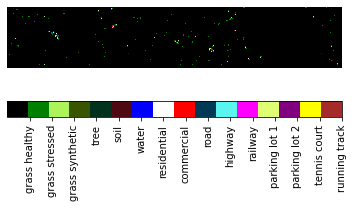

In [45]:
# visualize the training sample and save it
printImage(
    ["black", "green", "#AEF359", "#395500", "#013220", "#4f0a11",  "blue", "white", "red",
     "#003955", "#5bf5f0", "magenta", "#deff73", "purple", "yellow", "brown"],
    TrLabel,
    '/content/drive/MyDrive/landcover/train.png')

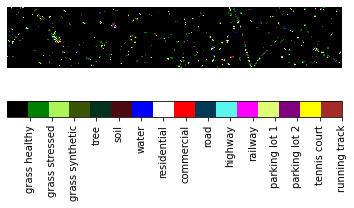

In [46]:
# visualize the test sample and save it
printImage(
    ["black", "green", "#AEF359", "#395500", "#013220", "#4f0a11",  "blue", "white", "red",
     "#003955", "#5bf5f0", "magenta", "#deff73", "purple", "yellow", "brown"],
    TsLabel,
    '/content/drive/MyDrive/landcover/test.png')

In [47]:
# normalize data
Data = normalizeData(Data)

Mean of the dataset is 6787.30517578125, standard deviation is 2853.2119140625


In [48]:
# constuct data for the network
TrainData, TrainDataLabel, TestData, TestDataLabel, TotalData, m , n, l = constructDataForNetwork(Data, TrLabel, TsLabel)

Training size is [2832, 144, 1], testing size is: [12197, 144, 1]


In [49]:
# constuct data loaders
Classes, train_loader_full, train_loader, test_loader, val_loader = constructDataLoaders(
    TrainData, TrainDataLabel, TestData, TestDataLabel)

number of training samples 2548
number of validation samples 284
Data has 15 classes


In [50]:
# define hyperparameters which you want to train with
hyper_config = {
    "learning_rate" : [0.001],
    "gru_num_layers" : [2],
    "gru_hidden_size" : [80],
    "dropout" : [0, 0.3, 0.5, 0.7],
}

In [56]:
# define a path to a file where the training expetiments are saved
history_file = '/content/drive/MyDrive/landcover/RNN/hyper_params/history_dropouts'

In [57]:
# train with the defined above parameters
_, times = trainForHyperparams(hyper_config, history_file, train_loader, val_loader)

Learning rate 0.001, gru layers 2, hidden_layers 80, dropout 0
GRU(
  (GRU): GRU(1, 80, num_layers=2, batch_first=True)
  (out): Linear(in_features=80, out_features=15, bias=True)
)
Epoch:  0 | train loss: 0.0146 | val loss: 0.1803 | train accuracy: 0.1480 | val accuracy: 0.1327
Epoch:  1 | train loss: 0.0130 | val loss: 0.1639 | train accuracy: 0.1354 | val accuracy: 0.1293
Epoch:  2 | train loss: 0.0123 | val loss: 0.1577 | train accuracy: 0.1900 | val accuracy: 0.2007
Epoch:  3 | train loss: 0.0117 | val loss: 0.1516 | train accuracy: 0.2449 | val accuracy: 0.2245
Epoch:  4 | train loss: 0.0110 | val loss: 0.1402 | train accuracy: 0.3148 | val accuracy: 0.2993
Epoch:  5 | train loss: 0.0103 | val loss: 0.1327 | train accuracy: 0.3595 | val accuracy: 0.3469
Epoch:  6 | train loss: 0.0098 | val loss: 0.1280 | train accuracy: 0.3752 | val accuracy: 0.3707
Epoch:  7 | train loss: 0.0095 | val loss: 0.1269 | train accuracy: 0.4093 | val accuracy: 0.3741
Epoch:  8 | train loss: 0.0093 | v

In [58]:
# load the experiments history that you want to plot
history_loaded = readHistory(history_file)

In [59]:
folder = "/content/drive/MyDrive/landcover/RNN/hyper_params/dropouts/dropouts_"

Learning rate 0.001, gru layers 2, hidden_layers 80, dropout 0


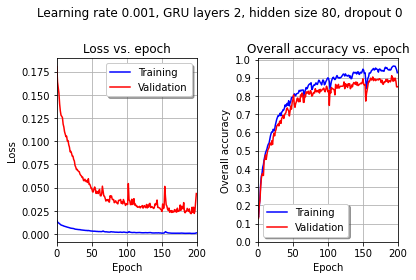

Learning rate 0.001, gru layers 2, hidden_layers 80, dropout 0.3


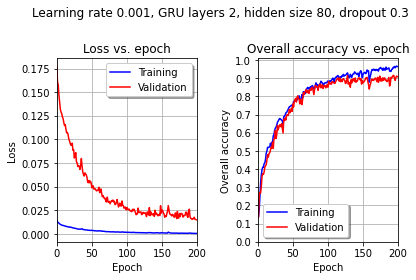

Learning rate 0.001, gru layers 2, hidden_layers 80, dropout 0.5


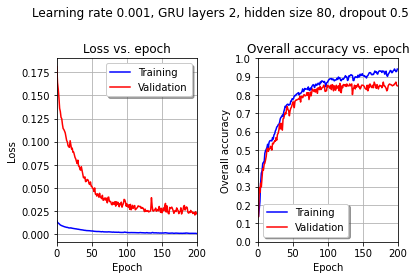

Learning rate 0.001, gru layers 2, hidden_layers 80, dropout 0.7


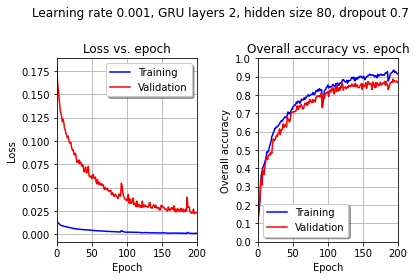

In [60]:
# plot the training experiments to choose the best hyperparameters
plotHistory(history_loaded, hyper_config , folder)

## Evaluation of the model on the test data

In [61]:
# choose the best hyperparameters from the analysis of the training experiments 
# perfomed on the validation dataset
best_lr = 0.001
best_num_layers = 2
best_hidden_size = 80
best_dropout = 0.3

In [ ]:
# time of training for a model with the best hyperparameters
for t in times:
  if t["lr"] == best_lr and t["gru_num_layers"] == best_num_layers and \
   t["gru_hidden_size"] == best_hidden_size and t["dropout"] == best_dropout:
    print("Training time is {}".format(t["time"]))

Training time is 68.79630064964294


In [62]:
# load the model with the chosen parameters
rnn = GRU(hidden_size = best_hidden_size, num_layers = best_num_layers, dropout = best_dropout)

In [63]:
# count the number of trainable parameters
params = 0
for p in rnn.parameters():
  if p.requires_grad:
    params += p.numel()
print("The number of trainable parameters in the model is {}".format(params))

The number of trainable parameters in the model is 60015


In [64]:
# load the weights from the training experiment with the best results
rnn.to(device)
rnn.eval()

rnn.load_state_dict(torch.load('/content/drive/MyDrive/landcover/RNN/model_weights/net_params_RNN_{}_{}_{}_{}.pkl'.format(
    best_lr, best_num_layers, best_hidden_size, best_dropout)))

<All keys matched successfully>

In [65]:
rnn.to(device)
rnn.eval()

GRU(
  (GRU): GRU(1, 80, num_layers=2, batch_first=True, dropout=0.3)
  (out): Linear(in_features=80, out_features=15, bias=True)
)

In [ ]:
# apply a trained model on the test data and measure testing time
start_y = time.time()
pred_y = predictData(rnn, TestData, len(TestDataLabel))
end_y = time.time()
time_y = end_y - start_y 

In [ ]:
print("Testing time is {} sec".format(time_y))

Testing time is 0.14175724983215332 sec


In [ ]:
# compute overall accuracy
OA = computeOverallAccuracy(pred_y, TestDataLabel)
print('Overall accuracy is: {}'.format(OA.data.cpu().numpy()))

Overall accuracy is: 0.7616627216339111


In [ ]:
# compute accuracy for each class
EachAcc = computeAccuracyForEachClass(pred_y, TestDataLabel, Classes)
print('Accuracies for each class are \n\n{}'.format(EachAcc.data.cpu().numpy()))

Accuracies for each class are 

[0.82241213 0.931391   0.9940594  0.905303   0.9185606  0.97902095
 0.7145522  0.4169041  0.7261568  0.65444016 0.7267552  0.568684
 0.55789477 0.9716599  0.9640592 ]


In [ ]:
# compute average accuracy
AA = computeAvarageAccuracy(pred_y, TestDataLabel, Classes)
print('Avarage accuracy is: {}'.format(AA.data.cpu().numpy()))

Avarage accuracy is: 0.7901235818862915


In [ ]:
# compute cohen_score
cohen_score = cohen_kappa_score(pred_y, TestDataLabel)
print('Cohen\'s kappa is: {}'.format(cohen_score))

Cohen's kappa is: 0.7421594158620568


In [ ]:
# apply a trained model on all data and measure time
start_all = time.time()
pred_all = predictData(rnn, TotalData, m*n)
end_all = time.time()
pred_all = torch.reshape(pred_all, (m, n)) + 1

In [ ]:
# efficiecy (pixel per second)
pixel_for_sec = (m * n) / (end_all - start_all)
print("Efficiecy, (pixel per second) {}".format(pixel_for_sec))

Efficiecy, (pixel per second) 102344.42398547589


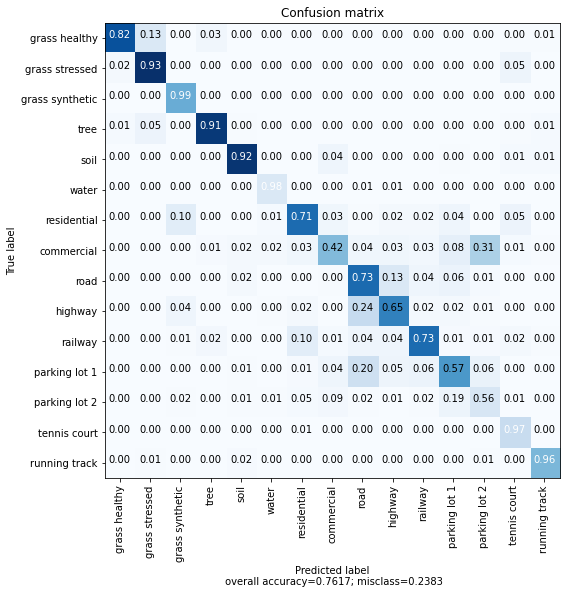

In [ ]:
# produce confusion matrix
cm = confusion_matrix(TestDataLabel, pred_y)
plot_confusion_matrix(cm,['grass healthy', 'grass stressed', 'grass synthetic',
                           'tree', 'soil', 'water', 'residential', 'commercial', 
                           'road', 'highway', 'railway', 'parking lot 1', 
                           'parking lot 2', 'tennis court', 'running track'],
                      '/content/drive/MyDrive/landcover/RNN_confusion.png',
                      title='Confusion matrix',
                      cmap=None,normalize=True)

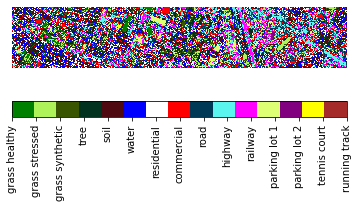

In [ ]:
# create segmantation map and save it
printImage(
    ["green", "#AEF359", "#395500", "#013220", "#4f0a11",  "blue", "white", "red",
     "#003955", "#5bf5f0", "magenta", "#deff73", "purple", "yellow", "brown"],
    pred_all,
    '/content/drive/MyDrive/landcover/segmentation_map_RNN.png')